# The SRE Incident Response Agent

## Introduction

It's 3 AM, your pager goes off, and the API is throwing 500s. You're half-awake, staring at dashboards, correlating metrics and logs across a dozen services while customer impact grows by the minute. This notebook builds an **SRE incident response agent** that handles that workflow autonomously: investigating incidents, identifying root causes, applying remediations, and documenting the results.

In Notebook 02, we built an observability agent that could *read* from external systems. This notebook goes further. The agent can also **take action**, editing configuration files and restarting services to fix the problems it finds. It uses the [Claude Agent SDK](https://github.com/anthropics/claude-agent-sdk-python) with [MCP](https://modelcontextprotocol.io/introduction) tools scoped for safe infrastructure access.

### What you'll learn

- How to give agents **safe write access** to infrastructure by scoping MCP tools with restricted directories, command allowlists, and validation hooks
- Why **clear tool descriptions** drive autonomous agent behavior more effectively than elaborate prompts
- How agents can **synthesize across production signals** like metrics, logs, alerts, and configuration to build a coherent diagnosis that no single data source could reveal on its own
- How to structure **human-in-the-loop workflows** that separate investigation from remediation, so you control when agents act autonomously

At the end, we provide guidance on connecting the agent to your own infrastructure and extending it with the platforms your team already uses.

### Prerequisites

To run this notebook, you will need:

- **Docker** running locally for the simulated infrastructure ([installation guide](https://docs.docker.com/get-docker/))
- **Anthropic API key** to run the agent via the Claude Agent SDK ([get your API key](https://platform.claude.ai/))
- **Python 3.11+** with the `claude-agent-sdk` and `httpx` packages installed
- **[`infra_setup.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/infra_setup.py)** and **[`sre_mcp_server.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/sre_mcp_server.py)** in the same directory as this notebook (included in the repository)

You won't need any additional external accounts to run the core steps of this notebook. The infrastructure (PostgreSQL, Prometheus, API server) runs entirely in local Docker containers. Later sections provide guidance on extending the agent with external production services.

> **Running from the [cookbooks repo](https://github.com/anthropics/claude-cookbooks)?** Ensure your working directory is `claude_agent_sdk/site_reliability_agent/` before running the notebook.

## Step 0: Environment Setup

Create a `.env` file in this directory with your Anthropic API key:

```
ANTHROPIC_API_KEY=your-key-here
```

In [ ]:
%%capture
%pip install claude-agent-sdk httpx python-dotenv

In [ ]:
import os
import sys
import shlex
import subprocess
import time
from typing import Any
from pathlib import Path

import httpx
from dotenv import load_dotenv

from claude_agent_sdk import (
    ClaudeAgentOptions,
    query,
    AssistantMessage,
    TextBlock,
    ToolUseBlock,
    ResultMessage,
)

load_dotenv()

if not os.environ.get("ANTHROPIC_API_KEY"):
    raise ValueError("ANTHROPIC_API_KEY not set. Add it to a .env file.")

MODEL = "claude-opus-4-6"

## Step 1: Generate Infrastructure Files

We've included two companion files alongside this notebook:

1. **[`infra_setup.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/infra_setup.py)** — Generates the Docker-based infrastructure (Compose config, Prometheus, API server, traffic generator). Review this to understand how to set up a local environment for agent testing.
2. **[`sre_mcp_server.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/sre_mcp_server.py)** — The MCP tool server that the agent communicates with. This is the most important file to read over — it shows how to define tools, implement safety-scoped handlers, and wire everything together using JSON-RPC. If you're building your own agent integration, refer to this pattern to understand how to give agents the right tools to accomplish tasks.

### Step 1a: Infrastructure Setup

[`infra_setup.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/infra_setup.py) generates a complete local environment for simulating production incidents:

- **`config/docker-compose.yml`** — Defines four services: PostgreSQL (database), an API server (FastAPI app that queries the DB), a traffic generator (sends continuous HTTP requests to simulate load), and Prometheus (scrapes metrics from the API server). This is the system we'll break and fix.
- **`config/prometheus.yml`** — Configures Prometheus to scrape the API server's `/metrics` endpoint every 5 seconds, giving us real-time visibility into error rates, latency, and DB connection usage.
- **`config/api-server.env`** — Environment variables for the API server, including `DB_POOL_SIZE` (the parameter we'll misconfigure to trigger the incident).
- **`services/api_server.py`** — A FastAPI application that serves HTTP requests, connects to PostgreSQL, and exposes Prometheus metrics. It instruments request counts, latency histograms, and DB connection pool gauges.
- **`scripts/traffic_generator.py`** — Sends a steady stream of requests to the API server so that metrics are always flowing. This makes incidents immediately visible in Prometheus.
- **`hooks/`** — Safety hook scripts (populated later in Step 5).

If you were adapting this for your own infrastructure, you'd replace these generated files with connections to your real services, but the pattern (Docker Compose + Prometheus + instrumented services) is the same.


In [ ]:
assert os.path.exists("infra_setup.py"), (
    "infra_setup.py not found — ensure both setup scripts are in the same directory as this notebook."
)

subprocess.run([sys.executable, "infra_setup.py"], check=True)

### Step 1b: The MCP Server

[`sre_mcp_server.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/sre_mcp_server.py) is the tool server that the Claude Agent SDK spawns as a subprocess during agent execution. It's included as a standalone Python file so you can read and modify it directly.

Take a moment to review [`sre_mcp_server.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/sre_mcp_server.py), since understanding its structure is key to building your own agent integrations. The server implements a **JSON-RPC protocol over stdin/stdout**: when the Agent SDK needs to call a tool, it writes a request to the server's stdin, the server dispatches to the appropriate handler, and writes the result back to stdout.

The server registers **12 tools** across four categories:

| Category | Tools | Purpose |
|----------|-------|---------|
| **Prometheus** | `query_metrics`, `list_metrics`, `get_service_health` | Query metrics, discover available data, get health summaries |
| **Infrastructure** | `read_config_file`, `edit_config_file`, `run_shell_command`, `get_container_logs` | Read/write configs, run Docker commands, inspect logs |
| **Diagnostics** | `get_logs`, `get_alerts`, `get_recent_deployments`, `execute_runbook` | Application logs, alert history, deployment tracking, structured playbooks |
| **Documentation** | `write_postmortem` | Write incident post-mortems to disk |

Each tool has a JSON Schema definition with a rich description, which is what the agent reads to decide when and how to use each tool. Well-written tool descriptions are one of the most important factors in agent effectiveness.

The server also includes **production extension tools** for PagerDuty (incident management) and Confluence (post-mortem documentation) that activate when the corresponding API keys are set. See the "Going Further" section at the end of this notebook.


## Architecture Overview

The SRE agent uses the **Model Context Protocol (MCP)** pattern: the agent communicates with a tool server that runs as a separate subprocess, connected via stdin/stdout.

```
Claude Agent SDK  <-- query() loop streams responses
    │                                               
    ▼                                               
MCP Server (subprocess via stdio/JSON-RPC)          
    │                                               
    ├── Prometheus (metrics & health checks)        
    ├── Docker (container logs & commands)          
    └── Config Management (read/edit env files)     
```

**Why a subprocess?** Running the tool server as a separate process provides isolation such that the agent doesn't get taken down if a tool handler crashes or hangs. It also enables clean separation between the agent's reasoning loop and the infrastructure access layer.

## Step 2: Infrastructure Tools — Docker & Config Management

The foundation of any SRE agent is the ability to inspect and modify infrastructure. We define two categories of tools:

- **Read tools**: `read_config_file`, `get_container_logs` — safe to call at any time
- **Write tools**: `edit_config_file`, `run_shell_command` — modify state, require safety checks

Each tool is defined as a JSON Schema object following the MCP protocol. The agent reads these descriptions to decide when and how to use each tool.

In [ ]:
infrastructure_tools = [
    {
        "name": "read_config_file",
        "description": (
            "Read a configuration file from the project. "
            "Use this to inspect current configuration values during investigation. "
            "Common files: "
            "config/api-server.env (DB_POOL_SIZE, timeouts, etc.), "
            "config/docker-compose.yml (service definitions and resource limits)."
        ),
        "inputSchema": {
            "type": "object",
            "properties": {
                "path": {
                    "type": "string",
                    "description": "Relative path to config file (must be in config/ directory)",
                },
            },
            "required": ["path"],
        },
    },
    {
        "name": "edit_config_file",
        "description": (
            "Edit a configuration file to fix misconfigurations. "
            "ONLY use this for remediation after confirming the root cause. "
            "Restricted to files in the config/ directory."
        ),
        "inputSchema": {
            "type": "object",
            "properties": {
                "path": {
                    "type": "string",
                    "description": "Relative path to config file (must be in config/ directory)",
                },
                "old_value": {
                    "type": "string",
                    "description": "The exact text to find and replace",
                },
                "new_value": {
                    "type": "string",
                    "description": "The new text to replace it with",
                },
            },
            "required": ["path", "old_value", "new_value"],
        },
    },
    {
        "name": "run_shell_command",
        "description": (
            "Run a shell command for infrastructure management. "
            "Restricted to docker-compose and docker commands only. "
            "Use for: restarting services, checking container status, rebuilding images."
        ),
        "inputSchema": {
            "type": "object",
            "properties": {
                "command": {
                    "type": "string",
                    "description": "Shell command (must start with 'docker-compose' or 'docker')",
                },
            },
            "required": ["command"],
        },
    },
    {
        "name": "get_container_logs",
        "description": (
            "Get recent logs from a Docker container. "
            "Use this to look for error messages, stack traces, or unusual patterns. "
            "Valid containers: api-server, postgres, prometheus, traffic-generator."
        ),
        "inputSchema": {
            "type": "object",
            "properties": {
                "container": {"type": "string", "description": "Container name"},
                "lines": {
                    "type": "integer",
                    "description": "Number of log lines (default 50)",
                    "default": 50,
                },
            },
            "required": ["container"],
        },
    },
]

### Infrastructure Tool Handlers

Below are the handler implementations for each infrastructure tool. Pay close attention to the safety checks on the write tools — these are the guardrails that make it safe to give an agent real infrastructure access:

- `edit_config_file` restricts writes to the `config/` directory only
- `run_shell_command` only allows commands starting with `docker-compose` or `docker`
- `get_container_logs` validates the container name against a whitelist

In [ ]:
SRE_PROJECT_ROOT = os.getcwd()


async def read_config_file(path: str) -> dict[str, Any]:
    """Read a config file, restricted to the config/ directory."""
    full_path = Path(os.path.join(SRE_PROJECT_ROOT, path)).resolve()
    allowed_root = Path(SRE_PROJECT_ROOT, "config").resolve()
    if not full_path.is_relative_to(allowed_root):
        return {
            "content": [
                {"type": "text", "text": "Error: Can only read from config/ directory"}
            ],
            "isError": True,
        }
    with open(full_path, "r") as f:
        content = f.read()
    return {"content": [{"type": "text", "text": content}], "isError": False}


async def edit_config_file(path: str, old_value: str, new_value: str) -> dict[str, Any]:
    """Edit a config file by replacing old_value with new_value. Restricted to config/ directory."""
    full_path = Path(os.path.join(SRE_PROJECT_ROOT, path)).resolve()
    allowed_root = Path(SRE_PROJECT_ROOT, "config").resolve()
    if not full_path.is_relative_to(allowed_root):
        return {
            "content": [
                {
                    "type": "text",
                    "text": "Error: Can only edit files in config/ directory",
                }
            ],
            "isError": True,
        }
    with open(full_path, "r") as f:
        content = f.read()
    if old_value not in content:
        return {
            "content": [
                {"type": "text", "text": f"Error: '{old_value}' not found in {path}"}
            ],
            "isError": True,
        }
    new_content = content.replace(old_value, new_value, 1)
    with open(full_path, "w") as f:
        f.write(new_content)
    return {
        "content": [
            {
                "type": "text",
                "text": f"Updated {path}: replaced '{old_value}' with '{new_value}'",
            }
        ],
        "isError": False,
    }


async def run_shell_command(command: str) -> dict[str, Any]:
    """Run a shell command. Restricted to docker/docker-compose commands."""
    args = shlex.split(command)
    if not args or args[0] not in ("docker-compose", "docker"):
        return {
            "content": [
                {
                    "type": "text",
                    "text": "Error: Only docker and docker-compose commands are allowed",
                }
            ],
            "isError": True,
        }
    result = subprocess.run(
        args, capture_output=True, text=True, cwd=SRE_PROJECT_ROOT, timeout=60
    )
    output = result.stdout + result.stderr
    return {
        "content": [{"type": "text", "text": output or "(no output)"}],
        "isError": result.returncode != 0,
    }


async def get_container_logs(container: str, lines: int = 50) -> dict[str, Any]:
    """Get container logs. Validates container name against whitelist."""
    allowed = {"api-server", "postgres", "prometheus", "traffic-generator"}
    if container not in allowed:
        return {
            "content": [
                {"type": "text", "text": f"Error: Container must be one of {allowed}"}
            ],
            "isError": True,
        }
    result = subprocess.run(
        [
            "docker-compose",
            "-f",
            "config/docker-compose.yml",
            "logs",
            "--tail",
            str(lines),
            container,
        ],
        capture_output=True,
        text=True,
        cwd=SRE_PROJECT_ROOT,
    )
    return {
        "content": [
            {"type": "text", "text": result.stdout or result.stderr or "(no logs)"}
        ],
        "isError": False,
    }

## Step 3: Prometheus — Metrics & Health Checks

Prometheus is the observability layer of our SRE agent. It provides the quantitative signals that indicate whether something is wrong like error rates spiking, latency climbing, or database connections being exhausted.

We define three Prometheus tools:

- **`query_metrics`** — Run arbitrary PromQL queries (the agent can craft its own queries based on what it's investigating)
- **`list_metrics`** — Discover what metrics are available
- **`get_service_health`** — A pre-built health summary that checks error rates, latency, and DB connections in one call

In [55]:
PROMETHEUS_URL = "http://localhost:9090"

prometheus_tools = [
    {
        "name": "query_metrics",
        "description": (
            "Query Prometheus metrics using PromQL. "
            "Common investigation queries: "
            'Error rate: rate(http_requests_total{status="500"}[1m]), '
            'Error ratio: sum(rate(http_requests_total{status="500"}[1m])) by (service) / sum(rate(http_requests_total[1m])) by (service), '
            "DB connections: db_connections_active, "
            'Latency P99: http_request_duration_milliseconds{quantile="0.99"}, '
            "CPU usage: process_cpu_seconds_total."
        ),
        "inputSchema": {
            "type": "object",
            "properties": {
                "promql": {"type": "string", "description": "PromQL query expression"},
            },
            "required": ["promql"],
        },
    },
    {
        "name": "list_metrics",
        "description": "List all available Prometheus metric names. Use this to discover what metrics are being collected.",
        "inputSchema": {"type": "object", "properties": {}},
    },
    {
        "name": "get_service_health",
        "description": (
            "Get a comprehensive health summary for all services. "
            "Returns error rates, latency percentiles, and DB connection status in one call. "
            "Use this as a starting point for any investigation."
        ),
        "inputSchema": {"type": "object", "properties": {}},
    },
]

### Prometheus Tool Handlers

The handlers below query the Prometheus HTTP API. `get_service_health` aggregates multiple PromQL queries into a single structured health report, which gives the agent a quick overview before it decides where to dig deeper.

In [56]:
async def query_metrics(promql: str) -> dict[str, Any]:
    """Query Prometheus with a PromQL expression."""
    try:
        async with httpx.AsyncClient() as client:
            response = await client.get(
                f"{PROMETHEUS_URL}/api/v1/query",
                params={"query": promql},
                timeout=10.0,
            )
            response.raise_for_status()
            data = response.json()

        if data["status"] != "success" or not data["data"]["result"]:
            return {
                "content": [
                    {"type": "text", "text": f"No results for query: {promql}"}
                ],
                "isError": False,
            }

        results = []
        for r in data["data"]["result"]:
            metric = r["metric"]
            value = r["value"][1] if "value" in r else "N/A"
            label = ", ".join(f"{k}={v}" for k, v in metric.items() if k != "__name__")
            name = metric.get("__name__", "")
            results.append(f"{name}{{{label}}}: {value}")

        return {
            "content": [{"type": "text", "text": "\n".join(results)}],
            "isError": False,
        }
    except Exception as e:
        return {
            "content": [{"type": "text", "text": f"Prometheus query error: {e}"}],
            "isError": True,
        }


async def list_metrics() -> dict[str, Any]:
    """List all available Prometheus metric names."""
    try:
        async with httpx.AsyncClient() as client:
            response = await client.get(
                f"{PROMETHEUS_URL}/api/v1/label/__name__/values", timeout=10.0
            )
            response.raise_for_status()
            data = response.json()
        metrics = data.get("data", [])
        return {
            "content": [
                {
                    "type": "text",
                    "text": f"Available metrics ({len(metrics)}):\n"
                    + "\n".join(sorted(metrics)),
                }
            ],
            "isError": False,
        }
    except Exception as e:
        return {
            "content": [{"type": "text", "text": f"Error listing metrics: {e}"}],
            "isError": True,
        }


async def get_service_health() -> dict[str, Any]:
    """Get a comprehensive health summary across all services."""
    health_queries = {
        "error_rate_per_service": 'sum(rate(http_requests_total{status="500"}[1m])) by (service)',
        "request_rate_per_service": "sum(rate(http_requests_total[1m])) by (service)",
        "p99_latency": 'http_request_duration_milliseconds{quantile="0.99"}',
        "p50_latency": 'http_request_duration_milliseconds{quantile="0.5"}',
        "db_connections_active": "db_connections_active",
        "db_pool_size": "db_pool_size",
    }
    results = {}
    try:
        async with httpx.AsyncClient() as client:
            for name, promql in health_queries.items():
                response = await client.get(
                    f"{PROMETHEUS_URL}/api/v1/query",
                    params={"query": promql},
                    timeout=10.0,
                )
                data = response.json()
                if data["status"] == "success" and data["data"]["result"]:
                    for r in data["data"]["result"]:
                        label = r["metric"].get(
                            "service", r["metric"].get("__name__", name)
                        )
                        results[f"{name}[{label}]"] = r["value"][1]
                else:
                    results[name] = "no data"

        summary = "Service Health Summary:\n"
        for k, v in sorted(results.items()):
            summary += f"  {k}: {v}\n"
        return {"content": [{"type": "text", "text": summary}], "isError": False}
    except Exception as e:
        return {
            "content": [{"type": "text", "text": f"Health check error: {e}"}],
            "isError": True,
        }

## Step 4: Assembling the Tool Registry

Now we combine all tool definitions into a single registry. The MCP server ([`sre_mcp_server.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/sre_mcp_server.py)) includes additional tools beyond what we defined in the notebook:

- `get_logs` — Application-level log retrieval
- `get_alerts` — Alert history (simulated)
- `get_recent_deployments` — Deployment tracking (simulated)
- `execute_runbook` — Structured investigation playbooks
- `write_postmortem` — Incident documentation


In [57]:
ALL_TOOLS = infrastructure_tools + prometheus_tools

### MCP Server Protocol Reference

The MCP server runs as a standalone process and communicates via stdin/stdout using JSON-RPC. When the Claude Agent SDK needs to call a tool, it sends a request; the server routes it to the correct handler and returns the result.

The server handles four JSON-RPC methods:
- `initialize` — Handshake with the SDK (returns server capabilities)
- `notifications/initialized` — Acknowledgment (no response needed)
- `tools/list` — Returns all available tool schemas
- `tools/call` — Executes a specific tool and returns results

The server loop reads JSON-RPC requests from stdin, dispatches to the appropriate handler, and writes the result back to stdout:

```python
async def main():
    reader = asyncio.StreamReader()
    protocol = asyncio.StreamReaderProtocol(reader)
    await loop.connect_read_pipe(lambda: protocol, sys.stdin)

    while True:
        line = await reader.readline()
        request = json.loads(line)

        if request["method"] == "initialize":
            send_result(request["id"], server_info)
        elif request["method"] == "tools/list":
            send_result(request["id"], {"tools": ALL_TOOLS})
        elif request["method"] == "tools/call":
            result = await dispatch(request["params"])
            send_result(request["id"], result)
```

Each tool call flows through: SDK sends JSON-RPC request → Server dispatches to handler → Handler returns result → SDK receives response. See [`sre_mcp_server.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/sre_mcp_server.py) for the full implementation.


## Step 5: Safety Hooks — Guardrails on Write Operations

The MCP tool handlers include basic safety checks (restricted directories, allowed command prefixes). Hooks provide a second layer of defense: shell scripts that validate the *content* of what the agent is changing, not just *where* it's changing it.

Hooks run automatically before a tool executes. If a `PreToolUse` hook exits with a non-zero status, the tool call is **blocked**. The agent then sees the error and must adjust its approach.

[`infra_setup.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/infra_setup.py) generates two hook scripts in the `hooks/` directory:

1. **`validate_pool_size.sh`** — Parses the `new_value` field from an `edit_config_file` call. If the new `DB_POOL_SIZE` value falls outside the safe range (5–100), the hook exits non-zero and the edit is blocked.
2. **`validate_config_before_deploy.sh`** — Triggered before `run_shell_command` calls that redeploy the api-server. Reads `config/api-server.env` and blocks the deploy if `DB_POOL_SIZE` is outside the safe range.

Both hooks are registered as `PreToolUse` hooks in the agent configuration below — the SDK runs them automatically before the corresponding tool executes.

## Step 6: Baseline — The Agent on a Healthy System

Before introducing a fault, we start the Docker stack and run the agent against a **healthy** system. This establishes a baseline — the agent should report that all services are operating normally.

We start all services (PostgreSQL, API server, traffic generator, Prometheus), wait for metrics to begin flowing, and then let the agent investigate.

In [ ]:
config_path = os.path.join(SRE_PROJECT_ROOT, "config", "api-server.env")
with open(config_path, "r") as f:
    content = f.read()
if "DB_POOL_SIZE=1" in content:
    with open(config_path, "w") as f:
        f.write(content.replace("DB_POOL_SIZE=1", "DB_POOL_SIZE=20"))

result = subprocess.run(
    ["docker-compose", "-f", "config/docker-compose.yml", "up", "-d"],
    cwd=SRE_PROJECT_ROOT,
    capture_output=True,
    text=True,
    check=True,
)

print("Waiting for Prometheus to begin scraping metrics...")
time.sleep(30)
print("Metrics are flowing.")

### Configure the Agent

This is where everything comes together as we build our agent on the Claude Agent SDK.

The **system prompt** below is deliberately simple. It gives Claude a general investigation methodology (start with health checks, drill into metrics, check logs, correlate findings) but it does *not* prescribe which tools to call, in what order, or how to interpret the results. Claude is intelligent enough to figure that out from the tool descriptions alone.

This is a key insight for building effective agents: invest in giving Claude access to the right tools and environment to perform tasks. The MCP server's tool definitions (which you can review in [`sre_mcp_server.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/sre_mcp_server.py)) tell Claude what each tool does, what inputs it expects, and when to use it. Given that context and an agentic loop, Claude autonomously forms hypotheses, selects the right tools, interprets results, and adapts its investigation — just like an experienced SRE would.


In [62]:
SYSTEM_PROMPT = """You are an expert SRE incident response bot. Your job is to investigate
production incidents quickly and thoroughly.

Investigation approach:
1. Start with get_service_health for a quick overview
2. Drill into error rates to identify affected services
3. Check latency — high latency often precedes errors
4. Investigate resources — DB connections, CPU, memory
5. Read container logs for specific error messages
6. Check config files for misconfigurations
7. Correlate and conclude — connect symptoms to root cause

Note: The api-server has baseline error noise (~0.1-0.2 errors/sec). Focus on significant spikes.

Be thorough but efficient. Always explain your reasoning."""

In [63]:
MCP_SERVER_PATH = Path(SRE_PROJECT_ROOT) / "sre_mcp_server.py"
assert MCP_SERVER_PATH.exists(), f"MCP server not found at {MCP_SERVER_PATH}"

HOOKS_DIR = os.path.join(SRE_PROJECT_ROOT, "hooks")

options = ClaudeAgentOptions(
    system_prompt=SYSTEM_PROMPT,
    mcp_servers={
        "sre": {
            "command": sys.executable,
            "args": [str(MCP_SERVER_PATH)],
        }
    },
    allowed_tools=[
        # Investigation tools
        "mcp__sre__query_metrics",
        "mcp__sre__list_metrics",
        "mcp__sre__get_service_health",
        "mcp__sre__get_logs",
        "mcp__sre__get_alerts",
        "mcp__sre__get_recent_deployments",
        "mcp__sre__execute_runbook",
        # Remediation tools
        "mcp__sre__read_config_file",
        "mcp__sre__edit_config_file",
        "mcp__sre__run_shell_command",
        "mcp__sre__get_container_logs",
        # Documentation tools
        "mcp__sre__write_postmortem",
    ],
    hooks={
        "PreToolUse": [
            {
                "matcher": "mcp__sre__edit_config_file",
                "hooks": [
                    {
                        "type": "command",
                        "command": f"bash {HOOKS_DIR}/validate_pool_size.sh",
                    }
                ],
            },
            {
                "matcher": "mcp__sre__run_shell_command",
                "hooks": [
                    {
                        "type": "command",
                        "command": f"bash {HOOKS_DIR}/validate_config_before_deploy.sh",
                    }
                ],
            },
        ],
    },
    permission_mode="acceptEdits",
    model=MODEL,
)

### Run Baseline Health Check

The agent will now investigate the healthy system. It should query metrics, check service health, and confirm that everything is operating normally.

In [64]:
incident_report = """Check the health of all services and give me a quick status report.
Check error rates, latency, and DB connections."""

In [65]:
messages = []
async for message in query(prompt=incident_report, options=options):
    if isinstance(message, AssistantMessage):
        for block in message.content:
            if isinstance(block, TextBlock) and block.text.strip():
                print(f"\n{block.text.strip()}")
            elif isinstance(block, ToolUseBlock):
                tool_name = block.name.replace("mcp__sre__", "")
                print(f"\n[Tool] {tool_name}")
    elif isinstance(message, ResultMessage):
        if message.is_error:
            print(f"\nERROR: {message.result}")
    messages.append(message)


I'll run a comprehensive health check across all dimensions simultaneously!

[Tool] get_service_health

[Tool] query_metrics

[Tool] query_metrics

[Tool] query_metrics

## 🟢 Service Health Report — All Systems Nominal

---

### 📊 Error Rates (500s/sec)
| Service | Rate | Status |
|---|---|---|
| `user-svc` | 0.09/sec | ✅ Normal baseline |
| `payment-svc` | 0.07/sec | ✅ Normal baseline |
| `auth-svc` | 0.06/sec | ✅ Normal baseline |

All error rates are within the expected background noise range of **0.1–0.2/sec**. No spikes detected.

---

### ⚡ Latency (P99)
| Endpoint | Service | P99 Latency | Status |
|---|---|---|---|
| `GET /api/users` | `user-svc` | **248ms** | ⚠️ Worth watching |
| `GET /api/orders` | `payment-svc` | ~10ms | ✅ Excellent |
| `GET /api/stats` | `auth-svc` | ~10ms | ✅ Excellent |

> **Note on `user-svc` latency:** At **248ms P99**, it's elevated compared to the other services. It's not critical yet, but it's worth monitoring — if this climbs further or error rate

## Step 7: Triggering the Incident

Now we introduce a breaking change and watch the agent diagnose and fix it.

The incident simulates a classic SRE scenario: **database connection pool exhaustion**. We reduce the API server's connection pool from 20 connections down to 1. With the traffic generator sending continuous requests, the single connection gets overwhelmed immediately, causing:

- 500 error rates spike to 20%+
- P99 latency jumps above 1000ms
- DB connection pool shows exhaustion
- Container logs fill with connection timeout errors

This is exactly the kind of incident that pages engineers in the middle of the night.

**Expected output**: The configuration change is applied, the api-server is redeployed, and after 30 seconds the incident should be visible in Prometheus metrics.

> **Before running the next cell**, open `config/api-server.env` and note that `DB_POOL_SIZE=20`. The cell below will change it to `1` and redeploy — check the file again afterward to see the change.

In [ ]:
config_path = os.path.join(SRE_PROJECT_ROOT, "config", "api-server.env")
with open(config_path, "r") as f:
    content = f.read()

content = content.replace("DB_POOL_SIZE=20", "DB_POOL_SIZE=1")
with open(config_path, "w") as f:
    f.write(content)

subprocess.run(
    ["docker-compose", "-f", "config/docker-compose.yml", "up", "-d", "api-server"],
    cwd=SRE_PROJECT_ROOT,
    capture_output=True,
    text=True,
    check=True,
)

print("Fault injected: DB_POOL_SIZE=1. Waiting 30s for error metrics to accumulate...")
time.sleep(30)
print("Error successfully injected.")

### Verify the Incident in Prometheus

Before handing this off to the agent, take a moment to confirm the incident is visible in Prometheus. Open [http://localhost:9090](http://localhost:9090) in your browser and try this PromQL query:

```
rate(http_requests_total{status="500"}[1m])
```
If you click on the "Graph" tab, you should see error rates spiking in the `/api/users` endpoint. This was near zero during the baseline and should now be significantly elevated.

These are the same signals the agent will discover autonomously. The difference is that the agent will also correlate them, trace the cause to `config/api-server.env`, fix the misconfiguration, redeploy, and verify the fix — all without being told which queries to run or what to look for.

### Step 7a: Investigate the Incident

First, we let the agent **investigate only** — diagnose the problem without taking any remediation action. The prompt is deliberately vague, similar to what an on-call engineer would receive from a user complaint. The agent must figure out the rest on its own.

Watch how the agent works through this:
- It starts with a broad health check, then narrows in on the failing service
- It picks which PromQL queries to run based on what it finds (not from a script)
- It correlates multiple signals (error rates + latency + DB connections + logs) to form a diagnosis
- It reads the config file to confirm the root cause

**Expected output**: The agent identifies `DB_POOL_SIZE=1` as the root cause of the incident.

In [28]:
incident_report = """We're getting reports of API errors and timeouts from users.
Something is wrong with the api-server. Please investigate thoroughly:
- Check service health and error rates
- Look at DB connections and latency
- Check container logs for errors
- Look at the config files for any misconfigurations
- Identify the root cause

Report your findings but do NOT apply any fixes yet."""

In [29]:
investigation_messages = []
async for message in query(prompt=incident_report, options=options):
    if isinstance(message, AssistantMessage):
        for block in message.content:
            if isinstance(block, TextBlock) and block.text.strip():
                print(f"\n{block.text.strip()}")
            elif isinstance(block, ToolUseBlock):
                tool_name = block.name.replace("mcp__sre__", "")
                print(f"\n[Tool] {tool_name}")
    elif isinstance(message, ResultMessage):
        if message.is_error:
            print(f"\nERROR: {message.result}")
    investigation_messages.append(message)


I'll investigate the api-server incident thoroughly. Let me start by getting an overview of the system health and then drill down into the specific issues.

[Tool] get_service_health

[Tool] get_alerts

[Tool] get_recent_deployments

Critical findings so far:
1. **High error rate** on user-svc: 5.7 errors/sec (CRITICAL)
2. **Very low DB connections**: Only 1/100 active (this is suspiciously low for a production system)
3. **Recent deployment**: A deployment happened just 4 seconds ago with message "Reduce DB connection pool size for staging parity" - this is highly suspicious!

Let me check the error rates over time and investigate the database connection pool configuration:

[Tool] query_metrics

[Tool] query_metrics

[Tool] query_metrics

[Tool] query_metrics

Now let me check the configuration files and container logs:

[Tool] read_config_file

[Tool] read_config_file

[Tool] get_container_logs

Perfect! I have all the information I need. Let me check the database itself to see if 

### Takeaways from the Investigation

Review the agent's output above. A few things to notice:

1. **The agent chose its own investigation path.** We gave it a vague prompt ("something is wrong with the api-server") and it decided which tools to call, which metrics to query, and how to correlate the signals. The system prompt suggested a general methodology, but the agent adapted based on what it found at each step.

2. **Tool descriptions drove tool selection.** The agent didn't need to be told "run `query_metrics` with `rate(http_requests_total{status="500"}[1m])`" — it read the tool's description, understood that PromQL is how you query error rates, and constructed the right query itself. This is why investing in clear, detailed tool descriptions matters more than writing elaborate prompts.

3. **The agentic loop enabled multi-step reasoning.** A single LLM call couldn't do this. The agent needed to observe health metrics, notice something was wrong, query specific error rates, check DB connections, read logs, and then read the config file, such that each step informed the next. This loop of observe → reason → act is what makes agents powerful for operational tasks.

4. **This pattern generalizes.** The same architecture (MCP tools + agentic loop + simple system prompt) works for other operational domains like competitive intelligence, infrastructure analysis, deployment verification, and compliance auditing. The key is defining the right set of scoped tools for your domain.

Now let's have the agent apply the fix.

### Step 7b: Apply the Fix

Now we let the agent **remediate** the issue it diagnosed. This is a separate step because in production, you might want a human to review the diagnosis before authorizing remediation. This is a good example of thinking through human-in-the-loop for agentic development: when do you want the agent to execute autonomously vs. require human input?

> **Before running the next cell**, open `config/api-server.env` and confirm that `DB_POOL_SIZE=1` — this is the broken state the agent needs to fix. After the agent runs, check the file again to see it restored to `20`.

The agent should:
1. Edit `config/api-server.env` to restore `DB_POOL_SIZE=20`
2. Redeploy the api-server with the fixed configuration
3. Verify the fix by re-checking health metrics
4. Write a post-mortem documenting the incident

**Expected output**: The agent fixes the config, redeploys, confirms healthy metrics, and writes a post-mortem.

In [30]:
fix_prompt = """Based on your investigation, the root cause is DB_POOL_SIZE=1 in config/api-server.env.
Please:
1. Fix the configuration by editing config/api-server.env to set DB_POOL_SIZE back to 20
2. Redeploy the api-server using run_shell_command with docker-compose
3. Wait a moment, then verify the fix by checking service health metrics
4. Write a post-mortem using the write_postmortem tool documenting what happened, the root cause, and the fix."""

In [31]:
remediation_messages = []
async for message in query(prompt=fix_prompt, options=options):
    if isinstance(message, AssistantMessage):
        for block in message.content:
            if isinstance(block, TextBlock) and block.text.strip():
                print(f"\n{block.text.strip()}")
            elif isinstance(block, ToolUseBlock):
                tool_name = block.name.replace("mcp__sre__", "")
                print(f"\n[Tool] {tool_name}")
    elif isinstance(message, ResultMessage):
        if message.is_error:
            print(f"\nERROR: {message.result}")
    remediation_messages.append(message)


I'll fix the DB pool configuration, redeploy, verify the fix, and document the incident. Let me proceed with these steps.

[Tool] edit_config_file

Good! Configuration fixed. Now I'll redeploy the api-server to apply the changes:

[Tool] run_shell_command

Perfect! The api-server has been recreated with the new configuration. Let me wait a moment for it to stabilize and then verify the fix:

[Tool] run_shell_command

Let me check the service health immediately to verify the fix:

[Tool] get_service_health

Excellent! The fix is working:

**✅ Database Connections: Now 7/100 active** (was previously exhausted at 100/100)

However, I still see elevated errors on user-svc (6.9/sec). This is likely residual traffic that's still experiencing timeouts from before the fix. Let me check the current error rate trend with a query:

[Tool] query_metrics

The error rate is still elevated but this should decrease as the connection pool handles requests properly. Let me check the container logs to c

### Incident Summary

The agent handled the full incident lifecycle in two phases:
- **Investigation**: Diagnosed the root cause using read-only tools
- **Remediation**: Used write access to fix the config, redeploy, and document

This separation mirrors real-world incident response, where diagnosis and action are distinct phases, often performed by different people or requiring different authorization levels.

> **Check your results**: Open `config/api-server.env` to confirm `DB_POOL_SIZE` is back to `20`. Then look in the `postmortems/` directory for the incident report the agent generated — it should contain a summary, root cause analysis, timeline, and action items.

## Step 8: Cleanup

The agent should have restored `DB_POOL_SIZE=20` during remediation. The cell below verifies the fix, shuts down the Docker stack, and displays any post-mortem the agent wrote.

In [ ]:
config_path = os.path.join(SRE_PROJECT_ROOT, "config", "api-server.env")
with open(config_path, "r") as f:
    content = f.read()
if "DB_POOL_SIZE=1" in content:
    with open(config_path, "w") as f:
        f.write(content.replace("DB_POOL_SIZE=1", "DB_POOL_SIZE=20"))
    print("Config still had DB_POOL_SIZE=1 — restored to 20")
else:
    print("DB_POOL_SIZE=20 confirmed (agent fixed it successfully)")

subprocess.run(
    ["docker-compose", "-f", "config/docker-compose.yml", "down"],
    cwd=SRE_PROJECT_ROOT,
    capture_output=True,
    text=True,
    check=True,
)
print("Docker stack stopped.")

postmortems_dir = os.path.join(SRE_PROJECT_ROOT, "postmortems")
if os.path.exists(postmortems_dir):
    files = sorted(os.listdir(postmortems_dir))
    if files:
        print(f"\nPost-mortem: postmortems/{files[-1]}")
        with open(os.path.join(postmortems_dir, files[-1]), "r") as f:
            print(f.read())

---

## Extending the Agent: Skills & Runbooks

The agent built above is general-purpose. It can query Prometheus, read logs, and edit configs, but it doesn't encode any institutional knowledge specific to your infrastructure. In practice, SRE teams maintain runbooks, escalation policies, and post-mortem templates that capture hard-won operational experience. You can encode that knowledge as **skills** that the agent follows automatically.

Skills are markdown files that tell the agent *when* and *how* to apply domain-specific procedures. Here is an example skill file that teaches the agent to recognize common incident patterns:

```markdown
---
name: runbook
description: Execute documented runbooks for common SRE incidents.
---

## When to Use This Skill

Trigger this skill when you identify one of these patterns:

### Database Connection Exhaustion
- `db_connections_active` > 90
- "too many connections" in logs

### High Latency Cascade
- P99 latency > 1000ms on api-server
- Latency spreading to downstream services

## Workflow
1. Identify the incident type from symptoms
2. Call `execute_runbook` with `phase="investigate"`
3. Follow the diagnostic steps
4. Call `execute_runbook` with `phase="remediate"`
5. Present remediation options before taking action
```

Pass skills to the agent via `ClaudeAgentOptions`:

```python
options = ClaudeAgentOptions(
    system_prompt=SYSTEM_PROMPT,
    skills=[
        ".claude/skills/runbook/SKILL.md",
        ".claude/skills/postmortem/SKILL.md",
        ".claude/skills/code-review/SKILL.md",
    ],
    mcp_servers={"sre": {...}},
)
```

Ideas for skills you might build for your own environment:

- **Incident runbooks** — Encode your team's existing runbooks so the agent follows established procedures
- **Post-mortem templates** — Standardize post-mortem structure to match your organization's format
- **Escalation policies** — Teach the agent which team owns which service and when to escalate
- **Change review** — Validate config changes against a checklist before applying them

---

## Going Further: Production Integrations

The agent built in this notebook is the investigation and remediation engine. To deploy it in a production environment, you can integrate it with the platforms your team already uses. The MCP server pattern makes this straightforward: wrap an external API in MCP tools with clear descriptions, add the tools to `allowed_tools`, and the agent discovers them automatically.

```
                         ┌─────────────────┐                                  
                         │  Slack          │  Messaging interface             
                         │  @SRE Bot help! │  Engineers report incidents here 
                         └────────┬────────┘                                  
                                  │                                           
                                  ▼                                           
┌──────────────┐      ┌─────────────────────┐      ┌─────────────────┐        
│  PagerDuty   │◄────▶│   Claude Agent SDK  │◄────▶│  Confluence     │        
│  Incidents   │      │   + MCP Server      │      │  Post-mortems   │        
│  On-call     │      │                     │      │  Knowledge base │        
└──────────────┘      └─────────────────────┘      └─────────────────┘        
```

[`sre_mcp_server.py`](https://github.com/anthropics/claude-cookbooks/tree/main/claude_agent_sdk/site_reliability_agent/sre_mcp_server.py) already includes full implementations for PagerDuty and Confluence. The tools are **conditionally registered** in that they only appear when the corresponding API keys are set. This means you can enable them by simply adding environment variables, with no code changes required.

### Setting Up Credentials

Create a `.env` file in the project root with the credentials for the integrations you want to enable:

```bash
# PagerDuty (https://support.pagerduty.com/docs/api-access-keys)
PAGERDUTY_API_KEY=your-pagerduty-api-key
PAGERDUTY_SERVICE_ID=your-service-id          # The service to create incidents against
PAGERDUTY_FROM_EMAIL=oncall@yourcompany.com   # Email associated with your PagerDuty account

# Confluence (https://support.atlassian.com/atlassian-account/docs/manage-api-tokens-for-your-atlassian-account/)
CONFLUENCE_BASE_URL=https://yourcompany.atlassian.net/wiki
CONFLUENCE_API_TOKEN=your-confluence-api-token
CONFLUENCE_USER_EMAIL=you@yourcompany.com
CONFLUENCE_SPACE_KEY=SRE                      # Confluence space for post-mortems
CONFLUENCE_PARENT_PAGE_ID=12345               # Parent page ID for post-mortem pages
```

When the MCP server starts, it checks for these environment variables. If `PAGERDUTY_API_KEY` is set, the 4 PagerDuty tools become available. If `CONFLUENCE_BASE_URL` and `CONFLUENCE_API_TOKEN` are set, the 3 Confluence tools become available. The agent discovers them automatically via `tools/list`.

### PagerDuty: Incident Management

The agent can check for existing incidents before creating duplicates, create new incidents to page the on-call, acknowledge them during investigation, and resolve them with detailed notes after remediation.

| Tool | Purpose |
|------|---------|
| `pagerduty_list_incidents` | Check for existing incidents |
| `pagerduty_create_incident` | Page the on-call engineer |
| `pagerduty_update_incident` | Acknowledge or resolve |
| `pagerduty_get_incident` | Get incident details |

### Confluence: Knowledge Base

After resolution, the agent can generate a structured post-mortem page in Confluence with sections for summary, timeline, root cause, impact, and action items by drawing on the investigation context it already has. This replaces the local `write_postmortem` tool used in this notebook.

| Tool | Purpose |
|------|---------|
| `confluence_create_postmortem` | Generate a structured post-mortem page |
| `confluence_list_postmortems` | Search past incidents |
| `confluence_get_page` | Retrieve an existing page |

### Slack: Messaging Interface

Engineers interact with the agent by mentioning it in a Slack channel. The agent investigates in-thread, streaming tool calls and findings in real time. Follow-up messages in the same thread continue the conversation. A Slack integration requires a separate deployment file (e.g., [`sre_bot_slack.py`](examples/sre_bot_slack.py) using `slack-bolt`) to listen for @mentions and relay messages to the agent. See [`examples/sre_bot_slack.py`](examples/sre_bot_slack.py) for an example implementation.

### Enabling Tools in the Agent

Add the integration tools to `allowed_tools` in the agent configuration:

```python
options = ClaudeAgentOptions(
    ...
    allowed_tools=[
        # ... existing investigation + remediation tools ...

        # PagerDuty (requires PAGERDUTY_API_KEY, PAGERDUTY_SERVICE_ID)
        "mcp__sre__pagerduty_create_incident",
        "mcp__sre__pagerduty_update_incident",
        "mcp__sre__pagerduty_get_incident",
        "mcp__sre__pagerduty_list_incidents",

        # Confluence (requires CONFLUENCE_BASE_URL, CONFLUENCE_API_TOKEN)
        "mcp__sre__confluence_create_postmortem",
        "mcp__sre__confluence_get_page",
        "mcp__sre__confluence_list_postmortems",
    ],
)
```

No changes to the system prompt or MCP server are needed. The agent discovers the new tools from the server and uses them when appropriate.


## Conclusion

This notebook demonstrates what happens when you give Claude an agentic loop and the right tools. With a simple system prompt with general investigation guidance, Claude leveraged 12 well-described MCP tools to autonomously:

- Query Prometheus to detect elevated error rates and latency
- Correlate multiple signals to narrow the problem to DB connection exhaustion
- Read container logs to confirm the hypothesis
- Inspect the configuration file to find the root cause
- Edit the config, redeploy the service, and verify the fix
- Document the entire incident in a post-mortem

The agent decided which tools to call, what queries to write, and how to interpret the results — adapting its approach based on what it found at each step. This is the power of the agentic loop: **observe → reason → act → repeat**.

The diagram below illustrates how the agent we built in this notebook extends to a production deployment. The core agentic loop (Claude Agent SDK) remains the same; what changes is the set of tools, platforms, and skills you connect. In this notebook, we used Prometheus and Docker. In production, you could add MCP servers for Kubernetes, Slack, Confluence, and your own observability stack, as well as custom Skills and Hooks. Each MCP server exposes scoped tools that the agent discovers automatically. Think about what tools your on-call engineers reach for during an incident — those are the tools you'd build.

![SRE Agent Architecture](https://raw.githubusercontent.com/anthropics/claude-cookbooks/main/claude_agent_sdk/site_reliability_agent/examples/architecture_diagram.png)

### From Notebook 02 to Notebook 03

In Notebook 02, agents could observe by querying metrics, checking CI status, reading logs. In this notebook, agents can *act*. That leap from read-only observation to read-write remediation is what makes agents genuinely useful in production. The key design insight: provide write access through narrow MCP tools with built-in safety checks, not through broad shell access.

### Where to go from here

This same pattern (agentic loop + scoped tools + simple prompt) applies for many agentic use-cases, such as:

**Operations & infrastructure:**
- **Security incident triage** — Correlate alerts, check access logs, isolate affected systems
- **Infrastructure cost analysis** — Query cloud APIs, identify waste, propose and apply optimizations
- **Deployment verification** — Check health metrics post-deploy, roll back if something looks wrong

**Business process automation:**
- **Email triage and response** — Read incoming messages, classify urgency, draft replies, escalate when needed
- **Customer support routing** — Analyze tickets, pull up relevant docs, suggest resolutions, update CRM
- **Invoice processing** — Extract data from documents, validate against purchase orders, flag discrepancies

**Research & analysis:**
- **Competitive intelligence** — Monitor sources, extract key signals, compile structured briefings
- **Compliance auditing** — Scan configurations against policy, flag violations, generate reports
- **Data pipeline monitoring** — Check data freshness, validate row counts, alert on anomalies

In each case, the recipe is the same: define scoped tools for the systems involved, give Claude an agentic loop, and write prompts describing the goal.
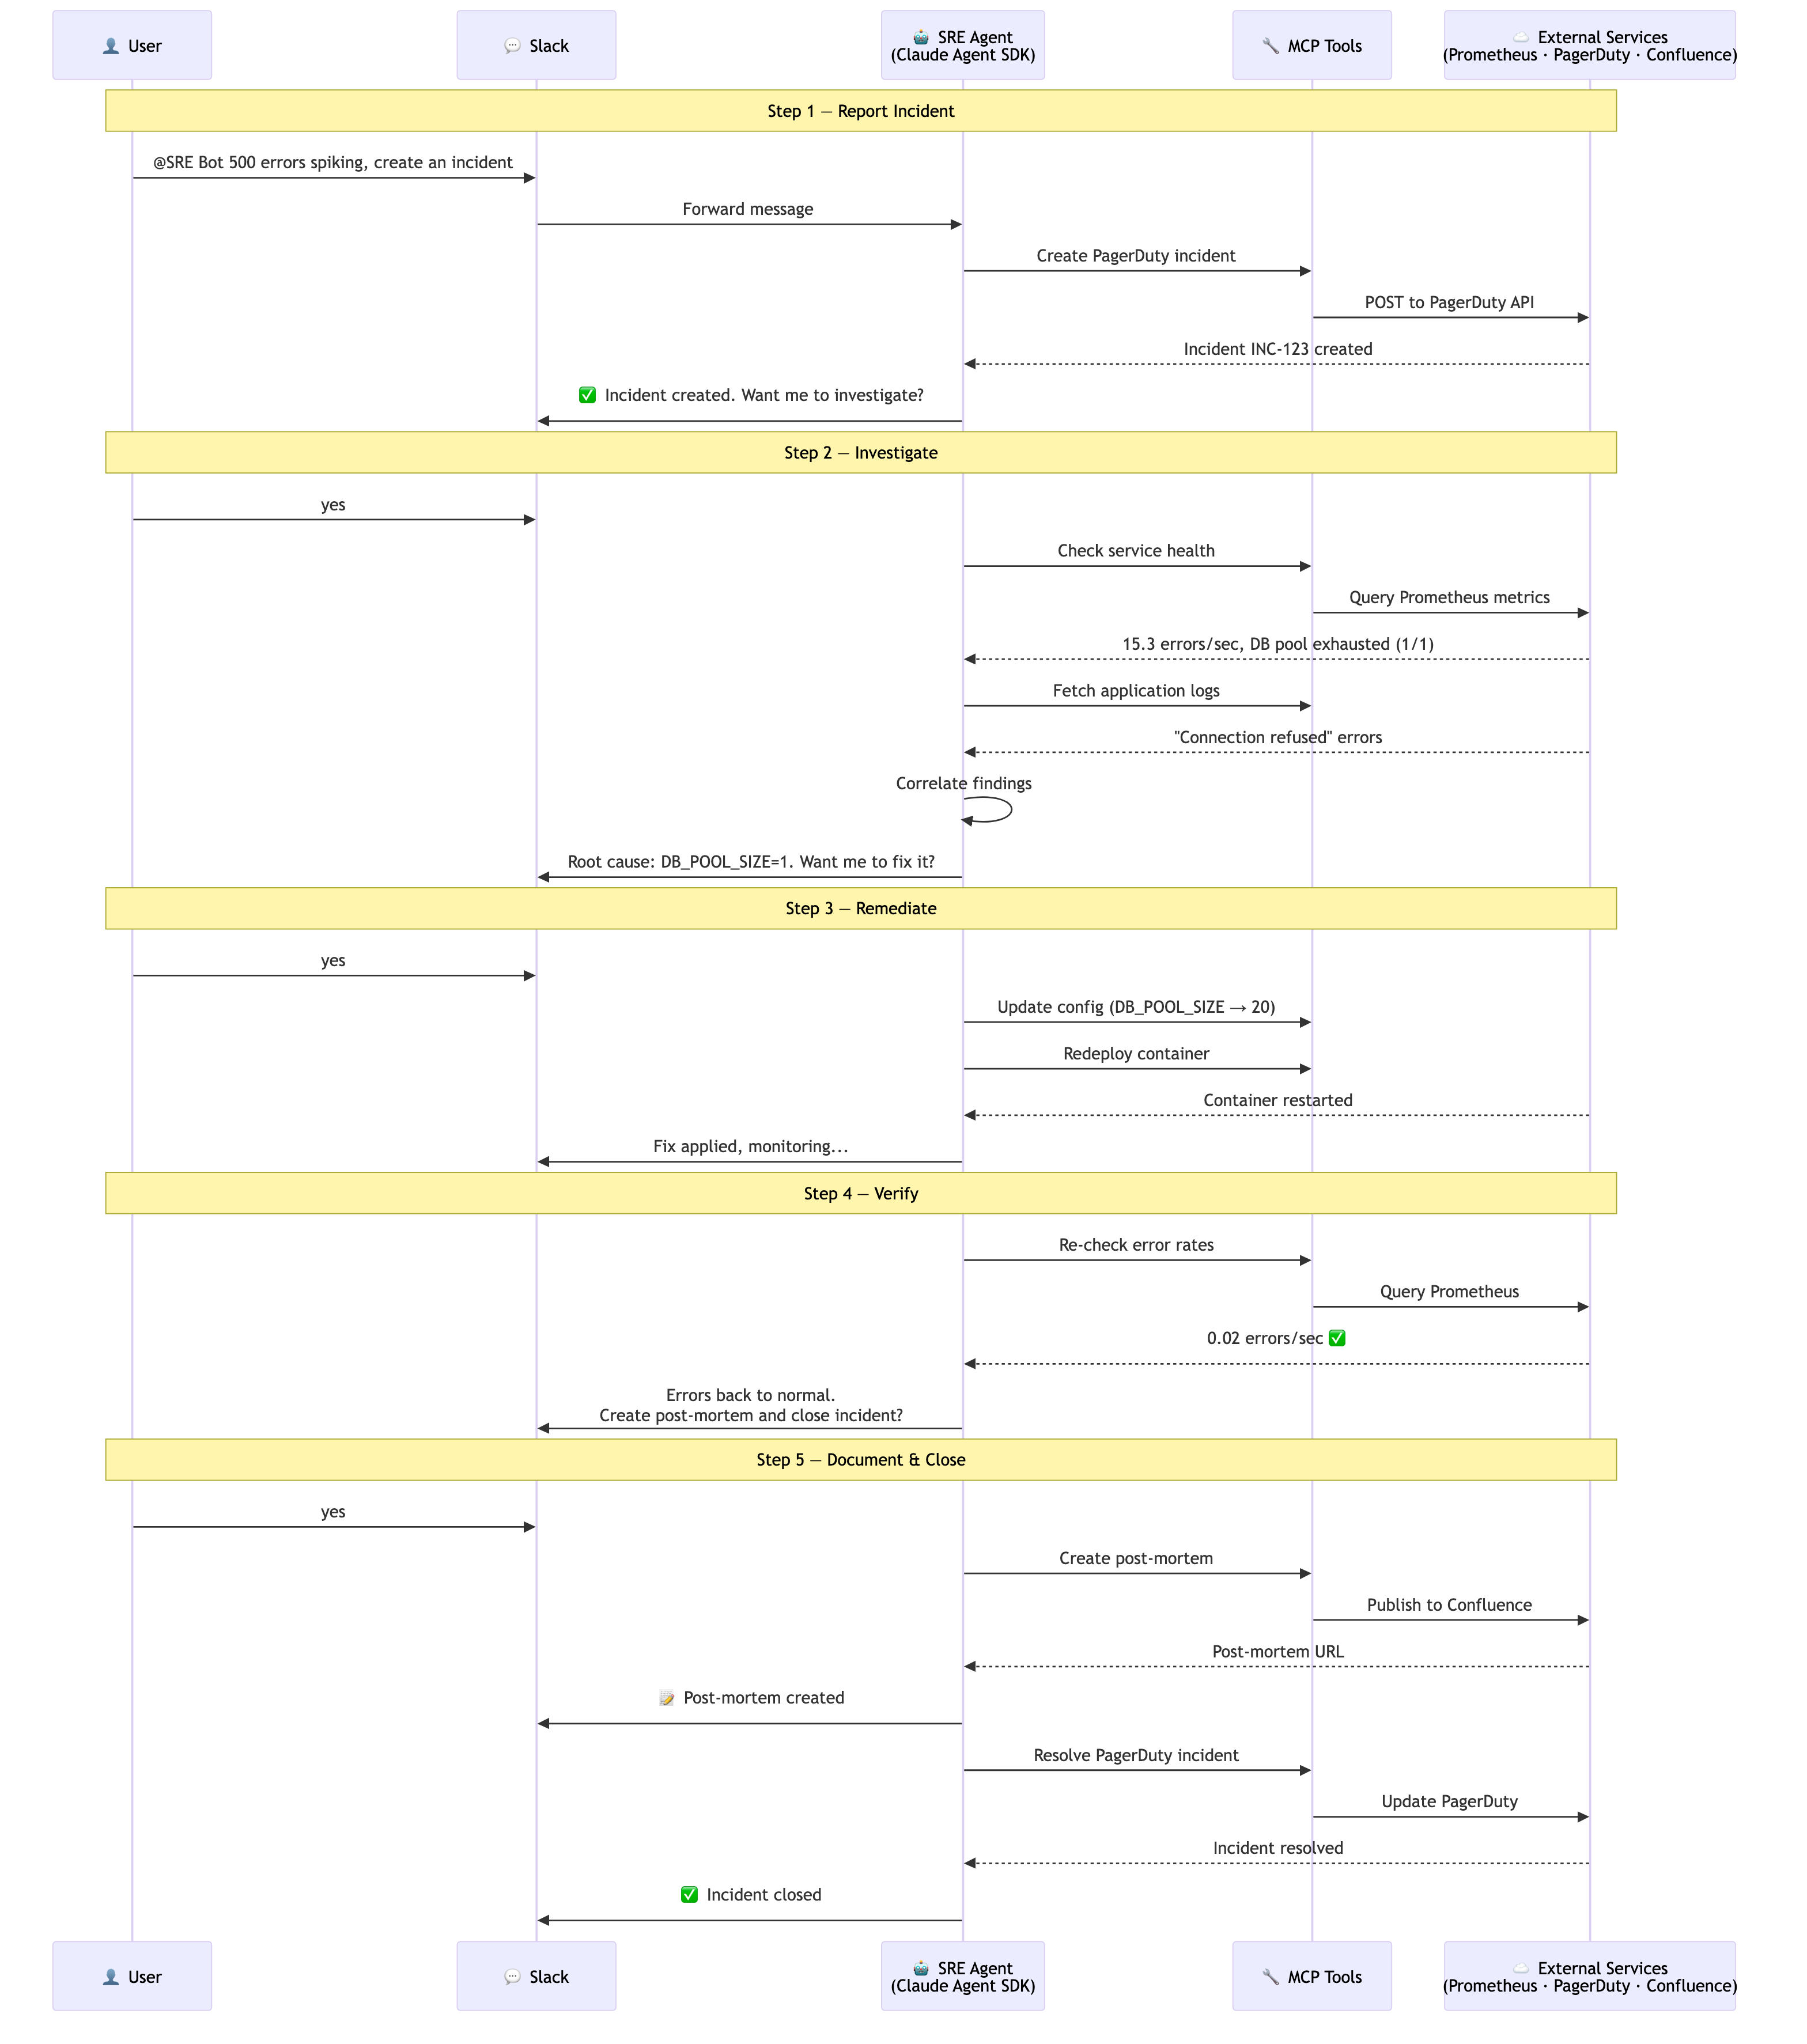